In [1]:
from sklearn import tree, ensemble, model_selection, metrics
from sklearn import svm
from sklearn import pipeline
from sklearn import neighbors
from sklearn import linear_model
from prettytable import PrettyTable
from yellowbrick.model_selection import FeatureImportances
from sklearn.preprocessing import label_binarize
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from scipy import interp
from itertools import cycle
import seaborn as sns
import pandas as pd
import numpy as np
import xgboost as xgb
import itertools
import warnings
warnings.filterwarnings('ignore')

C:\Users\Oishee Bhattacharyya\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [68]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("listing_data_clean_final_v3.csv")

print(df.shape)

(57636, 52)


Data Cleaning

In [69]:
df=df.drop(['review_scores_rating'],axis=1)

In [70]:
bed_type=pd.get_dummies(df['bed_type'],prefix='bed_type',drop_first=True)
df=pd.concat([df,bed_type],axis=1)
cancellation_policy=pd.get_dummies(df['cancellation_policy'],prefix='cancellation_policy',drop_first=True)
df=pd.concat([df,cancellation_policy],axis=1)
region=pd.get_dummies(df['region'],prefix='region',drop_first=True)
df=pd.concat([df,region],axis=1)
property_room_type=pd.get_dummies(df['property_room_type'],prefix='property_room_type',drop_first=True)
df=pd.concat([df,property_room_type],axis=1)

In [71]:
df=df.drop(['bed_type','cancellation_policy','region','property_room_type','property_room_type_Others_Entire home/apt',
            'property_room_type_Others_Hotel room','property_room_type_Others_Private room',
            'property_room_type_Others_Shared room'],axis=1)

In [73]:
df['review_scores_accuracy'] =  np.where((df['review_scores_accuracy'] >= 9), 2, 
                                np.where((df['review_scores_accuracy'] < 8),0,1))

In [74]:
df['review_scores_cleanliness'] =  np.where((df['review_scores_cleanliness'] >= 9), 2, 
                                np.where((df['review_scores_cleanliness'] < 8),0,1))

In [75]:
df['review_scores_checkin'] =  np.where((df['review_scores_checkin'] >= 9), 2, 
                                np.where((df['review_scores_checkin'] < 8),0,1))

In [76]:
df['review_scores_communication'] =  np.where((df['review_scores_communication'] >= 9), 2, 
                                np.where((df['review_scores_communication'] < 8),0,1))

In [77]:
df['review_scores_location'] =  np.where((df['review_scores_location'] >= 9), 2, 
                                np.where((df['review_scores_location'] < 8),0,1))

In [78]:
df['review_scores_value'] =  np.where((df['review_scores_value'] >= 9), 2, 
                                np.where((df['review_scores_value'] < 8),0,1))

### Based on Accuracy Rating

In [79]:
x = df[['host_response_rate', 'host_acceptance_rate', 'host_has_profile_pic',
       'host_identity_verified', 'is_location_exact', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'number_of_reviews_ltm', 
       'instant_bookable', 'require_guest_profile_picture',
       'require_guest_phone_verification',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'host_duration_days',
       'listing_duration_days', 'occupancy_rate', 'crime_rate', 'hangers',
       'washer', 'tv', 'detector', 'kitchen', 'heating', 'essentials', 'iron',
       'wifi', 'dryer', 'min_dist_subway', 'min_dist_park',
       'min_dist_attraction', 'recency', 'bed_type_Couch', 'bed_type_Futon',
       'bed_type_Pull-out Sofa', 'bed_type_Real Bed',
       'cancellation_policy_moderate', 'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period',
       'cancellation_policy_super_strict_30',
       'cancellation_policy_super_strict_60', 'region_East', 'region_North',
       'region_South', 'region_West',
       'property_room_type_Apartment_Hotel room',
       'property_room_type_Apartment_Private room',
       'property_room_type_Apartment_Shared room',
       'property_room_type_Bungalow_Entire home/apt',
       'property_room_type_Bungalow_Private room',
       'property_room_type_Bungalow_Shared room',
       'property_room_type_Guesthouse_Entire home/apt',
       'property_room_type_Guesthouse_Hotel room',
       'property_room_type_Guesthouse_Private room',
       'property_room_type_Guesthouse_Shared room',
       'property_room_type_Hotel_Entire home/apt',
       'property_room_type_Hotel_Hotel room',
       'property_room_type_Hotel_Private room',
       'property_room_type_Hotel_Shared room']]
y = df['review_scores_accuracy']
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 0.2, random_state = 610)

In [60]:
import time
from bayes_opt import BayesianOptimization
from sklearn import preprocessing, model_selection, metrics
import xgboost as xgb

start_time=time.time()

## Defining the function to be optimized
def xgb_evaluate(**param_range):
    params = {}
    params['num_class'] = 3
    params['objective'] = 'multi:softprob'
    params['eval_metric'] = 'mlogloss' 
    params['learning_rate']=param_range['learning_rate']
    params['colsample_bytree']=param_range['colsample_bytree']
    params['min_child_weight']=param_range['min_child_weight']
    params['max_depth']=int(round(param_range['max_depth']))
    params['subsample']=param_range['subsample']
    params['gamma']=param_range['gamma']
    xgb_train_data = xgb.DMatrix(x_train, label = y_train)
    cv_result = xgb.cv(params,xgb_train_data, num_boost_round = 100, nfold=5, seed=1234,
                       stratified=True,shuffle = True, metrics=('mlogloss'))
    return -min(cv_result['test-mlogloss-mean']) 

param_range={
'learning_rate':(0.05, 0.3),
'colsample_bytree': (0.1, 1),
'min_child_weight': (0.1, 1),
'max_depth': (4, 10),
'subsample':(0.6, 1),
'gamma':(0,0.5),
            }

bo = BayesianOptimization(xgb_evaluate, param_range)
bo.maximize(init_points = 5, n_iter = 20, acq = 'ei')

parameters = bo.max['params'] # Get the best parameters

final_parameters = {}

final_parameters.update({'booster':'gbtree'})

for k, v in parameters.items():
    if k in ['bagging_freq','min_data_in_leaf','max_depth','max_bin','num_leaves']:
        final_parameters[k] = int(round(v))
    else:
        final_parameters[k] = round(v,4)

final_parameters

print('Time taken:',round((time.time()-start_time)/60,2),'mins')

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------
|  1        | -2e-06    |  0.5074   |  0.2125   |  0.2373   |  5.451    |  0.1078   |  0.9969   |
|  2        | -0.001209 |  0.542    |  0.4837   |  0.06542  |  7.574    |  0.4471   |  0.6438   |
|  3        | -4e-06    |  0.5903   |  0.4528   |  0.1829   |  6.495    |  0.9456   |  0.6977   |
|  4        | -1e-06    |  0.3483   |  0.001967 |  0.2673   |  4.768    |  0.748    |  0.9531   |
|  5        | -1.4e-05  |  0.9291   |  0.2079   |  0.1274   |  6.861    |  0.4625   |  0.7848   |
|  6        | -2e-06    |  0.3033   |  0.03423  |  0.2179   |  4.66     |  0.8713   |  0.9973   |
|  7        | -4e-06    |  0.9882   |  0.1359   |  0.1805   |  6.337    |  0.5385   |  0.8436   |
|  8        | -0.000257 |  0.3484   |  0.3768   |  0.08149  |  5.589    |  0.8576   |  0.8495   |
|  9        | -0.000

In [80]:
# final model

import time
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import RandomizedSearchCV
from xgboost import cv
from xgboost import XGBClassifier

start_time=time.time()


xgb = XGBClassifier(objective='multi:softprob',eval_metric='mlogloss',
                    subsample=0.9531, n_estimators=100, min_child_weight=0.748, 
                    max_depth=5, colsample_bytree=0.3483, learning_rate=0.2673,
                    gamma=0.001967, random_state=42)

xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)

cf_matrix = metrics.confusion_matrix(y_test, y_pred)
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred,average="micro")
recall = metrics.recall_score(y_test, y_pred,average="micro")

report = """
=====================================================
* Evaluation Report of XGBoost Model Classification *
=====================================================

Confusion Matrix:
{}

Accuracy: {}
""".format(metrics.confusion_matrix(y_test, y_pred),
           metrics.accuracy_score(y_test, y_pred))
print(report)
print('The classification report of XGBoost:\n {}'
      .format(metrics.classification_report(y_test, y_pred)))

from sklearn.metrics import f1_score
print('micro averaging f1 score:', f1_score(y_test, y_pred, average='micro'))
print('macro averaging f1 score:', f1_score(y_test, y_pred, average='macro'))
print('weighted averaging f1 score:',f1_score(y_test, y_pred, average='weighted'))

print('Time taken:',round((time.time()-start_time)/60,2),'mins')


* Evaluation Report of XGBoost Model Classification *

Confusion Matrix:
[[   12     5   420]
 [    7     5   664]
 [   20    10 10385]]

Accuracy: 0.9023247744621791

The classification report of XGBoost:
               precision    recall  f1-score   support

           0       0.31      0.03      0.05       437
           1       0.25      0.01      0.01       676
           2       0.91      1.00      0.95     10415

    accuracy                           0.90     11528
   macro avg       0.49      0.34      0.34     11528
weighted avg       0.84      0.90      0.86     11528

micro averaging f1 score: 0.9023247744621791
macro averaging f1 score: 0.33796107118350566
weighted averaging f1 score: 0.8602162622514143
Time taken: 0.13 mins


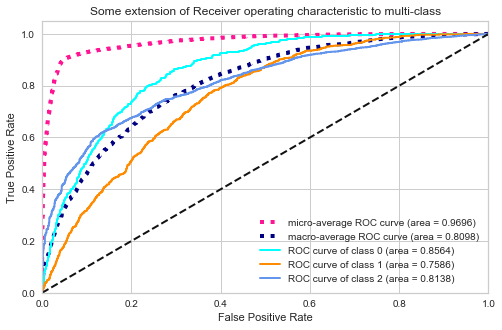

In [81]:
y_test = label_binarize(y_test, classes=[0,1,2])
n_classes = y_test.shape[1]
y_score = xgb.predict_proba(x_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
lw = 2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.4f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

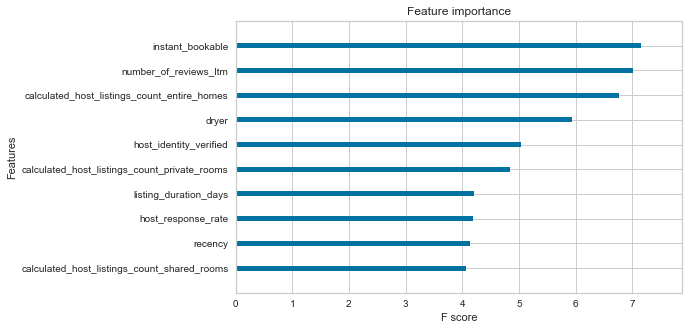

In [82]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 5)
#plot_importance(mymodel, importance_type='cover', max_num_features = 10,show_values=False)
plot_importance(xgb, importance_type='gain', max_num_features = 10,show_values=False)

### Based on Cleanliness Rating

In [83]:
x = df[['host_response_rate', 'host_acceptance_rate', 'host_has_profile_pic',
       'host_identity_verified', 'is_location_exact', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'number_of_reviews_ltm', 
       'instant_bookable', 'require_guest_profile_picture',
       'require_guest_phone_verification',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'host_duration_days',
       'listing_duration_days', 'occupancy_rate', 'crime_rate', 'hangers',
       'washer', 'tv', 'detector', 'kitchen', 'heating', 'essentials', 'iron',
       'wifi', 'dryer', 'min_dist_subway', 'min_dist_park',
       'min_dist_attraction', 'recency', 'bed_type_Couch', 'bed_type_Futon',
       'bed_type_Pull-out Sofa', 'bed_type_Real Bed',
       'cancellation_policy_moderate', 'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period',
       'cancellation_policy_super_strict_30',
       'cancellation_policy_super_strict_60', 'region_East', 'region_North',
       'region_South', 'region_West',
       'property_room_type_Apartment_Hotel room',
       'property_room_type_Apartment_Private room',
       'property_room_type_Apartment_Shared room',
       'property_room_type_Bungalow_Entire home/apt',
       'property_room_type_Bungalow_Private room',
       'property_room_type_Bungalow_Shared room',
       'property_room_type_Guesthouse_Entire home/apt',
       'property_room_type_Guesthouse_Hotel room',
       'property_room_type_Guesthouse_Private room',
       'property_room_type_Guesthouse_Shared room',
       'property_room_type_Hotel_Entire home/apt',
       'property_room_type_Hotel_Hotel room',
       'property_room_type_Hotel_Private room',
       'property_room_type_Hotel_Shared room']]
y = df['review_scores_cleanliness']
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 0.2, random_state = 610)

In [84]:
import time
from bayes_opt import BayesianOptimization
from sklearn import preprocessing, model_selection, metrics
import xgboost as xgb

start_time=time.time()

## Defining the function to be optimized
def xgb_evaluate(**param_range):
    params = {}
    params['num_class'] = 3
    params['objective'] = 'multi:softprob'
    params['eval_metric'] = 'mlogloss' 
    params['learning_rate']=param_range['learning_rate']
    params['colsample_bytree']=param_range['colsample_bytree']
    params['min_child_weight']=param_range['min_child_weight']
    params['max_depth']=int(round(param_range['max_depth']))
    params['subsample']=param_range['subsample']
    params['gamma']=param_range['gamma']
    xgb_train_data = xgb.DMatrix(x_train, label = y_train)
    cv_result = xgb.cv(params,xgb_train_data, num_boost_round = 100, nfold=5, seed=1234,
                       stratified=True,shuffle = True, metrics=('mlogloss'))
    return -min(cv_result['test-mlogloss-mean']) 

param_range={
'learning_rate':(0.05, 0.3),
'colsample_bytree': (0.1, 1),
'min_child_weight': (0.1, 1),
'max_depth': (4, 10),
'subsample':(0.6, 1),
'gamma':(0,0.5),
            }

bo = BayesianOptimization(xgb_evaluate, param_range)
bo.maximize(init_points = 5, n_iter = 20, acq = 'ei')

parameters = bo.max['params'] # Get the best parameters

final_parameters = {}

final_parameters.update({'booster':'gbtree'})

for k, v in parameters.items():
    if k in ['bagging_freq','min_data_in_leaf','max_depth','max_bin','num_leaves']:
        final_parameters[k] = int(round(v))
    else:
        final_parameters[k] = round(v,4)

final_parameters

print('Time taken:',round((time.time()-start_time)/60,2),'mins')

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------
|  1        | -0.4804   |  0.2166   |  0.3501   |  0.08974  |  8.529    |  0.4122   |  0.9762   |
|  2        | -0.4811   |  0.1972   |  0.2889   |  0.1578   |  7.595    |  0.3122   |  0.8482   |
|  3        | -0.4826   |  0.8713   |  0.2259   |  0.2745   |  5.777    |  0.702    |  0.6134   |
|  4        | -0.4789   |  0.6079   |  0.2044   |  0.2143   |  5.84     |  0.3021   |  0.9485   |
|  5        | -0.4796   |  0.6379   |  0.04297  |  0.243    |  6.593    |  0.3906   |  0.9742   |
|  6        | -0.4825   |  0.7976   |  0.2133   |  0.2575   |  8.571    |  0.6034   |  0.9736   |
|  7        | -0.4868   |  0.4559   |  0.09882  |  0.2581   |  9.479    |  0.6879   |  0.6344   |
|  8        | -0.4762   |  0.7145   |  0.3692   |  0.06532  |  8.412    |  0.6381   |  0.9203   |
|  9        | -0.481

In [85]:
# final model

import time
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import RandomizedSearchCV
from xgboost import cv
from xgboost import XGBClassifier

start_time=time.time()


xgb = XGBClassifier(objective='multi:softprob',eval_metric='mlogloss',
                    subsample=0.9203, n_estimators=100, min_child_weight=0.6381, 
                    max_depth=8, colsample_bytree=0.7145, learning_rate=0.06532,
                    gamma=0.3692, random_state=42)

# xgb._Booster.set_param({'num_class': 10})
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)

cf_matrix = metrics.confusion_matrix(y_test, y_pred)
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred,average="micro")
recall = metrics.recall_score(y_test, y_pred,average="micro")

report = """
=====================================================
* Evaluation Report of XGBoost Model Classification *
=====================================================

Confusion Matrix:
{}

Accuracy: {}
""".format(metrics.confusion_matrix(y_test, y_pred),
           metrics.accuracy_score(y_test, y_pred))
print(report)
print('The classification report of XGBoost:\n {}'
      .format(metrics.classification_report(y_test, y_pred)))

from sklearn.metrics import f1_score
print('micro averaging f1 score:', f1_score(y_test, y_pred, average='micro'))
print('macro averaging f1 score:', f1_score(y_test, y_pred, average='macro'))
print('weighted averaging f1 score:',f1_score(y_test, y_pred, average='weighted'))

print('Time taken:',round((time.time()-start_time)/60,2),'mins')


* Evaluation Report of XGBoost Model Classification *

Confusion Matrix:
[[  22   28  693]
 [  13   54 1091]
 [  10   35 9582]]

Accuracy: 0.8377862595419847

The classification report of XGBoost:
               precision    recall  f1-score   support

           0       0.49      0.03      0.06       743
           1       0.46      0.05      0.08      1158
           2       0.84      1.00      0.91      9627

    accuracy                           0.84     11528
   macro avg       0.60      0.36      0.35     11528
weighted avg       0.78      0.84      0.77     11528

micro averaging f1 score: 0.8377862595419847
macro averaging f1 score: 0.35113972209432415
weighted averaging f1 score: 0.7744475435854904
Time taken: 0.37 mins


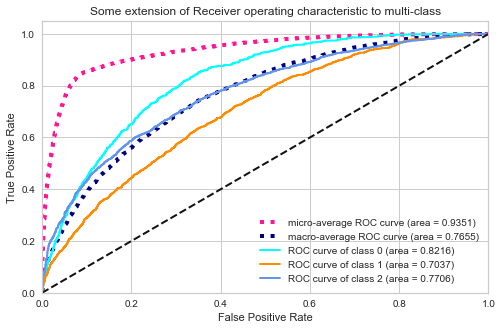

In [86]:
y_test = label_binarize(y_test, classes=[0,1,2])
n_classes = y_test.shape[1]
y_score = xgb.predict_proba(x_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
lw = 2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.4f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

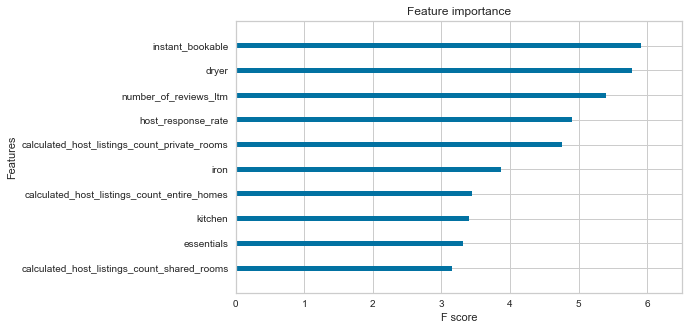

In [87]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 5)
#plot_importance(mymodel, importance_type='cover', max_num_features = 10,show_values=False)
plot_importance(xgb, importance_type='gain', max_num_features = 10,show_values=False)

### Based on Checkin Rating

In [88]:
x = df[['host_response_rate', 'host_acceptance_rate', 'host_has_profile_pic',
       'host_identity_verified', 'is_location_exact', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'number_of_reviews_ltm', 
       'instant_bookable', 'require_guest_profile_picture',
       'require_guest_phone_verification',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'host_duration_days',
       'listing_duration_days', 'occupancy_rate', 'crime_rate', 'hangers',
       'washer', 'tv', 'detector', 'kitchen', 'heating', 'essentials', 'iron',
       'wifi', 'dryer', 'min_dist_subway', 'min_dist_park',
       'min_dist_attraction', 'recency', 'bed_type_Couch', 'bed_type_Futon',
       'bed_type_Pull-out Sofa', 'bed_type_Real Bed',
       'cancellation_policy_moderate', 'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period',
       'cancellation_policy_super_strict_30',
       'cancellation_policy_super_strict_60', 'region_East', 'region_North',
       'region_South', 'region_West',
       'property_room_type_Apartment_Hotel room',
       'property_room_type_Apartment_Private room',
       'property_room_type_Apartment_Shared room',
       'property_room_type_Bungalow_Entire home/apt',
       'property_room_type_Bungalow_Private room',
       'property_room_type_Bungalow_Shared room',
       'property_room_type_Guesthouse_Entire home/apt',
       'property_room_type_Guesthouse_Hotel room',
       'property_room_type_Guesthouse_Private room',
       'property_room_type_Guesthouse_Shared room',
       'property_room_type_Hotel_Entire home/apt',
       'property_room_type_Hotel_Hotel room',
       'property_room_type_Hotel_Private room',
       'property_room_type_Hotel_Shared room']]
y = df['review_scores_checkin']
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 0.2, random_state = 610)

In [89]:
import time
from bayes_opt import BayesianOptimization
from sklearn import preprocessing, model_selection, metrics
import xgboost as xgb

start_time=time.time()

## Defining the function to be optimized
def xgb_evaluate(**param_range):
    params = {}
    params['num_class'] = 3
    params['objective'] = 'multi:softprob'
    params['eval_metric'] = 'mlogloss' 
    params['learning_rate']=param_range['learning_rate']
    params['colsample_bytree']=param_range['colsample_bytree']
    params['min_child_weight']=param_range['min_child_weight']
    params['max_depth']=int(round(param_range['max_depth']))
    params['subsample']=param_range['subsample']
    params['gamma']=param_range['gamma']
    xgb_train_data = xgb.DMatrix(x_train, label = y_train)
    cv_result = xgb.cv(params,xgb_train_data, num_boost_round = 100, nfold=5, seed=1234,
                       stratified=True,shuffle = True, metrics=('mlogloss'))
    return -min(cv_result['test-mlogloss-mean']) 

param_range={
'learning_rate':(0.05, 0.3),
'colsample_bytree': (0.1, 1),
'min_child_weight': (0.1, 1),
'max_depth': (4, 10),
'subsample':(0.6, 1),
'gamma':(0,0.5),
            }

bo = BayesianOptimization(xgb_evaluate, param_range)
bo.maximize(init_points = 5, n_iter = 20, acq = 'ei')

parameters = bo.max['params'] # Get the best parameters

final_parameters = {}

final_parameters.update({'booster':'gbtree'})

for k, v in parameters.items():
    if k in ['bagging_freq','min_data_in_leaf','max_depth','max_bin','num_leaves']:
        final_parameters[k] = int(round(v))
    else:
        final_parameters[k] = round(v,4)

final_parameters

print('Time taken:',round((time.time()-start_time)/60,2),'mins')

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------
|  1        | -0.2496   |  0.6514   |  0.04082  |  0.2761   |  4.775    |  0.6302   |  0.9748   |
|  2        | -0.2483   |  0.8463   |  0.02183  |  0.1022   |  5.089    |  0.1915   |  0.7104   |
|  3        | -0.252    |  0.3863   |  0.1519   |  0.1957   |  7.665    |  0.163    |  0.8265   |
|  4        | -0.2509   |  0.9059   |  0.05224  |  0.1551   |  9.174    |  0.7201   |  0.9036   |
|  5        | -0.2542   |  0.3216   |  0.4832   |  0.2523   |  8.002    |  0.4413   |  0.7216   |
|  6        | -0.2555   |  0.4754   |  0.01083  |  0.05     |  5.143    |  0.1      |  0.6      |
|  7        | -0.2533   |  0.1079   |  0.2055   |  0.1847   |  5.936    |  0.5163   |  0.7588   |
|  8        | -0.2493   |  0.6713   |  0.1762   |  0.05771  |  7.912    |  0.2391   |  0.7      |
|  9        | -0.252

In [90]:
# final model

import time
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import RandomizedSearchCV
from xgboost import cv
from xgboost import XGBClassifier

start_time=time.time()


xgb = XGBClassifier(objective='multi:softprob',eval_metric='mlogloss',
                    subsample=0.7815, n_estimators=100, min_child_weight=0.3068, 
                    max_depth=5, colsample_bytree=0.9054, learning_rate=0.1377,
                    gamma=0.0354, random_state=42)

# xgb._Booster.set_param({'num_class': 10})
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)

cf_matrix = metrics.confusion_matrix(y_test, y_pred)
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred,average="micro")
recall = metrics.recall_score(y_test, y_pred,average="micro")

report = """
=====================================================
* Evaluation Report of XGBoost Model Classification *
=====================================================

Confusion Matrix:
{}

Accuracy: {}
""".format(metrics.confusion_matrix(y_test, y_pred),
           metrics.accuracy_score(y_test, y_pred))
print(report)
print('The classification report of XGBoost:\n {}'
      .format(metrics.classification_report(y_test, y_pred)))

from sklearn.metrics import f1_score
print('micro averaging f1 score:', f1_score(y_test, y_pred, average='micro'))
print('macro averaging f1 score:', f1_score(y_test, y_pred, average='macro'))
print('weighted averaging f1 score:',f1_score(y_test, y_pred, average='weighted'))

print('Time taken:',round((time.time()-start_time)/60,2),'mins')


* Evaluation Report of XGBoost Model Classification *

Confusion Matrix:
[[    5     0   288]
 [    3     1   494]
 [    4     1 10732]]

Accuracy: 0.9314712005551701

The classification report of XGBoost:
               precision    recall  f1-score   support

           0       0.42      0.02      0.03       293
           1       0.50      0.00      0.00       498
           2       0.93      1.00      0.96     10737

    accuracy                           0.93     11528
   macro avg       0.62      0.34      0.33     11528
weighted avg       0.90      0.93      0.90     11528

micro averaging f1 score: 0.9314712005551701
macro averaging f1 score: 0.3338058961186247
weighted averaging f1 score: 0.899448255583694
Time taken: 0.31 mins


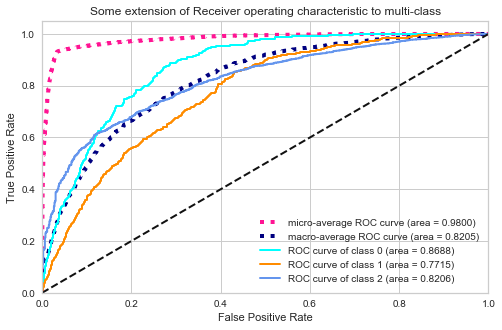

In [91]:
y_test = label_binarize(y_test, classes=[0,1,2])
n_classes = y_test.shape[1]
y_score = xgb.predict_proba(x_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
lw = 2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.4f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

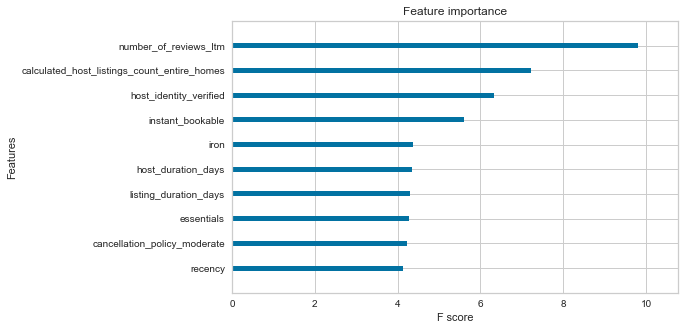

In [92]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 5)
#plot_importance(mymodel, importance_type='cover', max_num_features = 10,show_values=False)
plot_importance(xgb, importance_type='gain', max_num_features = 10,show_values=False)

### Based on Communication Rating

In [93]:
x = df[['host_response_rate', 'host_acceptance_rate', 'host_has_profile_pic',
       'host_identity_verified', 'is_location_exact', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'number_of_reviews_ltm', 
       'instant_bookable', 'require_guest_profile_picture',
       'require_guest_phone_verification',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'host_duration_days',
       'listing_duration_days', 'occupancy_rate', 'crime_rate', 'hangers',
       'washer', 'tv', 'detector', 'kitchen', 'heating', 'essentials', 'iron',
       'wifi', 'dryer', 'min_dist_subway', 'min_dist_park',
       'min_dist_attraction', 'recency', 'bed_type_Couch', 'bed_type_Futon',
       'bed_type_Pull-out Sofa', 'bed_type_Real Bed',
       'cancellation_policy_moderate', 'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period',
       'cancellation_policy_super_strict_30',
       'cancellation_policy_super_strict_60', 'region_East', 'region_North',
       'region_South', 'region_West',
       'property_room_type_Apartment_Hotel room',
       'property_room_type_Apartment_Private room',
       'property_room_type_Apartment_Shared room',
       'property_room_type_Bungalow_Entire home/apt',
       'property_room_type_Bungalow_Private room',
       'property_room_type_Bungalow_Shared room',
       'property_room_type_Guesthouse_Entire home/apt',
       'property_room_type_Guesthouse_Hotel room',
       'property_room_type_Guesthouse_Private room',
       'property_room_type_Guesthouse_Shared room',
       'property_room_type_Hotel_Entire home/apt',
       'property_room_type_Hotel_Hotel room',
       'property_room_type_Hotel_Private room',
       'property_room_type_Hotel_Shared room']]
y = df['review_scores_communication']
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 0.2, random_state = 610)

In [94]:
import time
from bayes_opt import BayesianOptimization
from sklearn import preprocessing, model_selection, metrics
import xgboost as xgb

start_time=time.time()

## Defining the function to be optimized
def xgb_evaluate(**param_range):
    params = {}
    params['num_class'] = 3
    params['objective'] = 'multi:softprob'
    params['eval_metric'] = 'mlogloss' 
    params['learning_rate']=param_range['learning_rate']
    params['colsample_bytree']=param_range['colsample_bytree']
    params['min_child_weight']=param_range['min_child_weight']
    params['max_depth']=int(round(param_range['max_depth']))
    params['subsample']=param_range['subsample']
    params['gamma']=param_range['gamma']
    xgb_train_data = xgb.DMatrix(x_train, label = y_train)
    cv_result = xgb.cv(params,xgb_train_data, num_boost_round = 100, nfold=5, seed=1234,
                       stratified=True,shuffle = True, metrics=('mlogloss'))
    return -min(cv_result['test-mlogloss-mean']) 

param_range={
'learning_rate':(0.05, 0.3),
'colsample_bytree': (0.1, 1),
'min_child_weight': (0.1, 1),
'max_depth': (4, 10),
'subsample':(0.6, 1),
'gamma':(0,0.5),
            }

bo = BayesianOptimization(xgb_evaluate, param_range)
bo.maximize(init_points = 5, n_iter = 20, acq = 'ei')

parameters = bo.max['params'] # Get the best parameters

final_parameters = {}

final_parameters.update({'booster':'gbtree'})

for k, v in parameters.items():
    if k in ['bagging_freq','min_data_in_leaf','max_depth','max_bin','num_leaves']:
        final_parameters[k] = int(round(v))
    else:
        final_parameters[k] = round(v,4)

final_parameters

print('Time taken:',round((time.time()-start_time)/60,2),'mins')

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------
|  1        | -0.241    |  0.7626   |  0.3084   |  0.2816   |  9.778    |  0.2757   |  0.9706   |
|  2        | -0.2354   |  0.4969   |  0.3167   |  0.2879   |  4.36     |  0.4277   |  0.8933   |
|  3        | -0.2353   |  0.389    |  0.029    |  0.2569   |  5.473    |  0.6555   |  0.7378   |
|  4        | -0.2393   |  0.9266   |  0.1339   |  0.1591   |  9.617    |  0.4296   |  0.6895   |
|  5        | -0.2409   |  0.2677   |  0.001704 |  0.2975   |  9.289    |  0.9385   |  0.8712   |
|  6        | -0.2341   |  0.897    |  0.05666  |  0.1259   |  4.949    |  0.7136   |  0.773    |
|  7        | -0.2381   |  1.0      |  0.5      |  0.05     |  5.02     |  1.0      |  0.6      |
|  8        | -0.2344   |  0.7537   |  0.0      |  0.206    |  4.932    |  0.455    |  0.9218   |
|  9        | -0.235

In [95]:
# final model

import time
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import RandomizedSearchCV
from xgboost import cv
from xgboost import XGBClassifier

start_time=time.time()


xgb = XGBClassifier(objective='multi:softprob',eval_metric='mlogloss',
                    subsample=0.773, n_estimators=100, min_child_weight=0.7136, 
                    max_depth=5, colsample_bytree=0.897, learning_rate=0.1259,
                    gamma=0.05666, random_state=42)

# xgb._Booster.set_param({'num_class': 10})
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)

cf_matrix = metrics.confusion_matrix(y_test, y_pred)
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred,average="micro")
recall = metrics.recall_score(y_test, y_pred,average="micro")

report = """
=====================================================
* Evaluation Report of XGBoost Model Classification *
=====================================================

Confusion Matrix:
{}

Accuracy: {}
""".format(metrics.confusion_matrix(y_test, y_pred),
           metrics.accuracy_score(y_test, y_pred))
print(report)
print('The classification report of XGBoost:\n {}'
      .format(metrics.classification_report(y_test, y_pred)))

from sklearn.metrics import f1_score
print('micro averaging f1 score:', f1_score(y_test, y_pred, average='micro'))
print('macro averaging f1 score:', f1_score(y_test, y_pred, average='macro'))
print('weighted averaging f1 score:',f1_score(y_test, y_pred, average='weighted'))

print('Time taken:',round((time.time()-start_time)/60,2),'mins')


* Evaluation Report of XGBoost Model Classification *

Confusion Matrix:
[[    6     3   289]
 [    1     1   440]
 [    8     5 10775]]

Accuracy: 0.9352879944482998

The classification report of XGBoost:
               precision    recall  f1-score   support

           0       0.40      0.02      0.04       298
           1       0.11      0.00      0.00       442
           2       0.94      1.00      0.97     10788

    accuracy                           0.94     11528
   macro avg       0.48      0.34      0.34     11528
weighted avg       0.89      0.94      0.91     11528

micro averaging f1 score: 0.9352879944482999
macro averaging f1 score: 0.3364959214552848
weighted averaging f1 score: 0.9058207158172961
Time taken: 0.3 mins


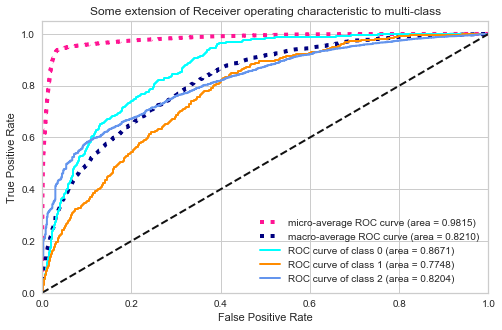

In [96]:
y_test = label_binarize(y_test, classes=[0,1,2])
n_classes = y_test.shape[1]
y_score = xgb.predict_proba(x_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
lw = 2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.4f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

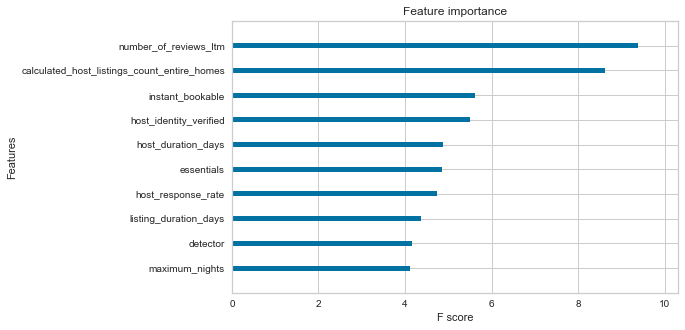

In [97]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 5)
#plot_importance(mymodel, importance_type='cover', max_num_features = 10,show_values=False)
plot_importance(xgb, importance_type='gain', max_num_features = 10,show_values=False)

### Based on Location Rating

In [98]:
x = df[['host_response_rate', 'host_acceptance_rate', 'host_has_profile_pic',
       'host_identity_verified', 'is_location_exact', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'number_of_reviews_ltm', 
       'instant_bookable', 'require_guest_profile_picture',
       'require_guest_phone_verification',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'host_duration_days',
       'listing_duration_days', 'occupancy_rate', 'crime_rate', 'hangers',
       'washer', 'tv', 'detector', 'kitchen', 'heating', 'essentials', 'iron',
       'wifi', 'dryer', 'min_dist_subway', 'min_dist_park',
       'min_dist_attraction', 'recency', 'bed_type_Couch', 'bed_type_Futon',
       'bed_type_Pull-out Sofa', 'bed_type_Real Bed',
       'cancellation_policy_moderate', 'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period',
       'cancellation_policy_super_strict_30',
       'cancellation_policy_super_strict_60', 'region_East', 'region_North',
       'region_South', 'region_West',
       'property_room_type_Apartment_Hotel room',
       'property_room_type_Apartment_Private room',
       'property_room_type_Apartment_Shared room',
       'property_room_type_Bungalow_Entire home/apt',
       'property_room_type_Bungalow_Private room',
       'property_room_type_Bungalow_Shared room',
       'property_room_type_Guesthouse_Entire home/apt',
       'property_room_type_Guesthouse_Hotel room',
       'property_room_type_Guesthouse_Private room',
       'property_room_type_Guesthouse_Shared room',
       'property_room_type_Hotel_Entire home/apt',
       'property_room_type_Hotel_Hotel room',
       'property_room_type_Hotel_Private room',
       'property_room_type_Hotel_Shared room']]
y = df['review_scores_location']
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 0.2, random_state = 610)

In [99]:
import time
from bayes_opt import BayesianOptimization
from sklearn import preprocessing, model_selection, metrics
import xgboost as xgb

start_time=time.time()

## Defining the function to be optimized
def xgb_evaluate(**param_range):
    params = {}
    params['num_class'] = 3
    params['objective'] = 'multi:softprob'
    params['eval_metric'] = 'mlogloss' 
    params['learning_rate']=param_range['learning_rate']
    params['colsample_bytree']=param_range['colsample_bytree']
    params['min_child_weight']=param_range['min_child_weight']
    params['max_depth']=int(round(param_range['max_depth']))
    params['subsample']=param_range['subsample']
    params['gamma']=param_range['gamma']
    xgb_train_data = xgb.DMatrix(x_train, label = y_train)
    cv_result = xgb.cv(params,xgb_train_data, num_boost_round = 100, nfold=5, seed=1234,
                       stratified=True,shuffle = True, metrics=('mlogloss'))
    return -min(cv_result['test-mlogloss-mean']) 

param_range={
'learning_rate':(0.05, 0.3),
'colsample_bytree': (0.1, 1),
'min_child_weight': (0.1, 1),
'max_depth': (4, 10),
'subsample':(0.6, 1),
'gamma':(0,0.5),
            }

bo = BayesianOptimization(xgb_evaluate, param_range)
bo.maximize(init_points = 5, n_iter = 20, acq = 'ei')

parameters = bo.max['params'] # Get the best parameters

final_parameters = {}

final_parameters.update({'booster':'gbtree'})

for k, v in parameters.items():
    if k in ['bagging_freq','min_data_in_leaf','max_depth','max_bin','num_leaves']:
        final_parameters[k] = int(round(v))
    else:
        final_parameters[k] = round(v,4)

final_parameters

print('Time taken:',round((time.time()-start_time)/60,2),'mins')

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------
|  1        | -0.2686   |  0.1737   |  0.1111   |  0.1599   |  9.423    |  0.2662   |  0.8015   |
|  2        | -0.2594   |  0.5157   |  0.07164  |  0.1378   |  4.747    |  0.7663   |  0.8308   |
|  3        | -0.2618   |  0.2082   |  0.2982   |  0.129    |  5.531    |  0.9147   |  0.8207   |
|  4        | -0.2684   |  0.1579   |  0.3799   |  0.08653  |  9.694    |  0.6932   |  0.8175   |
|  5        | -0.2687   |  0.2878   |  0.1821   |  0.2325   |  8.503    |  0.6217   |  0.8002   |
|  6        | -0.261    |  0.8747   |  0.0      |  0.1086   |  4.0      |  0.68     |  0.8491   |
|  7        | -0.2661   |  0.1      |  0.0      |  0.3      |  4.565    |  0.1      |  0.6      |
|  8        | -0.2675   |  0.8555   |  0.09829  |  0.05     |  4.763    |  1.0      |  0.9975   |
|  9        | -0.265

In [100]:
# final model

import time
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import RandomizedSearchCV
from xgboost import cv
from xgboost import XGBClassifier

start_time=time.time()


xgb = XGBClassifier(objective='multi:softprob',eval_metric='mlogloss',
                    subsample=0.8308, n_estimators=100, min_child_weight=0.7663, 
                    max_depth=5, colsample_bytree=0.5157, learning_rate=0.1378,
                    gamma=0.07164, random_state=42)

# xgb._Booster.set_param({'num_class': 10})
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)

cf_matrix = metrics.confusion_matrix(y_test, y_pred)
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred,average="micro")
recall = metrics.recall_score(y_test, y_pred,average="micro")

report = """
=====================================================
* Evaluation Report of XGBoost Model Classification *
=====================================================

Confusion Matrix:
{}

Accuracy: {}
""".format(metrics.confusion_matrix(y_test, y_pred),
           metrics.accuracy_score(y_test, y_pred))
print(report)
print('The classification report of XGBoost:\n {}'
      .format(metrics.classification_report(y_test, y_pred)))

from sklearn.metrics import f1_score
print('micro averaging f1 score:', f1_score(y_test, y_pred, average='micro'))
print('macro averaging f1 score:', f1_score(y_test, y_pred, average='macro'))
print('weighted averaging f1 score:',f1_score(y_test, y_pred, average='weighted'))

print('Time taken:',round((time.time()-start_time)/60,2),'mins')


* Evaluation Report of XGBoost Model Classification *

Confusion Matrix:
[[    0     2   236]
 [    0     4   644]
 [    0     7 10635]]

Accuracy: 0.922883414295628

The classification report of XGBoost:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       238
           1       0.31      0.01      0.01       648
           2       0.92      1.00      0.96     10642

    accuracy                           0.92     11528
   macro avg       0.41      0.34      0.32     11528
weighted avg       0.87      0.92      0.89     11528

micro averaging f1 score: 0.922883414295628
macro averaging f1 score: 0.32402345968625174
weighted averaging f1 score: 0.8868682205814616
Time taken: 0.16 mins


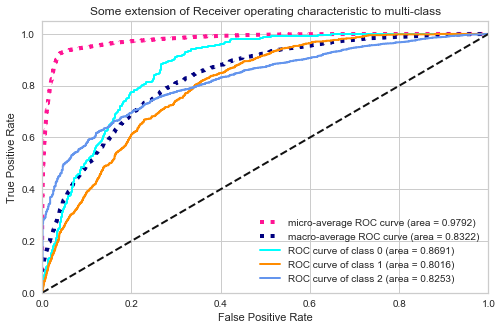

In [101]:
y_test = label_binarize(y_test, classes=[0,1,2])
n_classes = y_test.shape[1]
y_score = xgb.predict_proba(x_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
lw = 2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.4f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

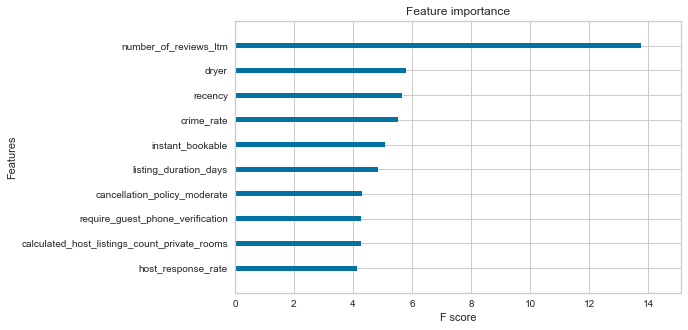

In [102]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 5)
#plot_importance(mymodel, importance_type='cover', max_num_features = 10,show_values=False)
plot_importance(xgb, importance_type='gain', max_num_features = 10,show_values=False)

### Based on Value Rating

In [103]:
x = df[['host_response_rate', 'host_acceptance_rate', 'host_has_profile_pic',
       'host_identity_verified', 'is_location_exact', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'number_of_reviews_ltm', 
       'instant_bookable', 'require_guest_profile_picture',
       'require_guest_phone_verification',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'host_duration_days',
       'listing_duration_days', 'occupancy_rate', 'crime_rate', 'hangers',
       'washer', 'tv', 'detector', 'kitchen', 'heating', 'essentials', 'iron',
       'wifi', 'dryer', 'min_dist_subway', 'min_dist_park',
       'min_dist_attraction', 'recency', 'bed_type_Couch', 'bed_type_Futon',
       'bed_type_Pull-out Sofa', 'bed_type_Real Bed',
       'cancellation_policy_moderate', 'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period',
       'cancellation_policy_super_strict_30',
       'cancellation_policy_super_strict_60', 'region_East', 'region_North',
       'region_South', 'region_West',
       'property_room_type_Apartment_Hotel room',
       'property_room_type_Apartment_Private room',
       'property_room_type_Apartment_Shared room',
       'property_room_type_Bungalow_Entire home/apt',
       'property_room_type_Bungalow_Private room',
       'property_room_type_Bungalow_Shared room',
       'property_room_type_Guesthouse_Entire home/apt',
       'property_room_type_Guesthouse_Hotel room',
       'property_room_type_Guesthouse_Private room',
       'property_room_type_Guesthouse_Shared room',
       'property_room_type_Hotel_Entire home/apt',
       'property_room_type_Hotel_Hotel room',
       'property_room_type_Hotel_Private room',
       'property_room_type_Hotel_Shared room']]
y = df['review_scores_value']
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 0.2, random_state = 610)

In [104]:
import time
from bayes_opt import BayesianOptimization
from sklearn import preprocessing, model_selection, metrics
import xgboost as xgb

start_time=time.time()

## Defining the function to be optimized
def xgb_evaluate(**param_range):
    params = {}
    params['num_class'] = 3
    params['objective'] = 'multi:softprob'
    params['eval_metric'] = 'mlogloss' 
    params['learning_rate']=param_range['learning_rate']
    params['colsample_bytree']=param_range['colsample_bytree']
    params['min_child_weight']=param_range['min_child_weight']
    params['max_depth']=int(round(param_range['max_depth']))
    params['subsample']=param_range['subsample']
    params['gamma']=param_range['gamma']
    xgb_train_data = xgb.DMatrix(x_train, label = y_train)
    cv_result = xgb.cv(params,xgb_train_data, num_boost_round = 100, nfold=5, seed=1234,
                       stratified=True,shuffle = True, metrics=('mlogloss'))
    return -min(cv_result['test-mlogloss-mean']) 

param_range={
'learning_rate':(0.05, 0.3),
'colsample_bytree': (0.1, 1),
'min_child_weight': (0.1, 1),
'max_depth': (4, 10),
'subsample':(0.6, 1),
'gamma':(0,0.5),
            }

bo = BayesianOptimization(xgb_evaluate, param_range)
bo.maximize(init_points = 5, n_iter = 20, acq = 'ei')

parameters = bo.max['params'] # Get the best parameters

final_parameters = {}

final_parameters.update({'booster':'gbtree'})

for k, v in parameters.items():
    if k in ['bagging_freq','min_data_in_leaf','max_depth','max_bin','num_leaves']:
        final_parameters[k] = int(round(v))
    else:
        final_parameters[k] = round(v,4)

final_parameters

print('Time taken:',round((time.time()-start_time)/60,2),'mins')

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------
|  1        | -0.4155   |  0.9433   |  0.3928   |  0.06733  |  6.367    |  0.1778   |  0.7126   |
|  2        | -0.4257   |  0.4177   |  0.4213   |  0.2802   |  9.577    |  0.205    |  0.8916   |
|  3        | -0.4146   |  0.5548   |  0.1179   |  0.1473   |  6.876    |  0.811    |  0.6585   |
|  4        | -0.4216   |  0.6883   |  0.3943   |  0.2862   |  8.885    |  0.4384   |  0.8279   |
|  5        | -0.4194   |  0.2587   |  0.001577 |  0.2987   |  6.034    |  0.6107   |  0.7765   |
|  6        | -0.4166   |  1.0      |  0.3764   |  0.05     |  7.074    |  0.616    |  0.6      |
|  7        | -0.4225   |  0.3782   |  0.0      |  0.05     |  7.049    |  0.3585   |  0.7592   |
|  8        | -0.4212   |  0.4072   |  0.2262   |  0.2437   |  9.04     |  0.257    |  0.9778   |
|  9        | -0.416

In [105]:
# final model

import time
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import RandomizedSearchCV
from xgboost import cv
from xgboost import XGBClassifier

start_time=time.time()


xgb = XGBClassifier(objective='multi:softprob',eval_metric='mlogloss',
                    subsample=0.7072, n_estimators=100, min_child_weight=0.8173, 
                    max_depth=7, colsample_bytree=0.4978, learning_rate=0.1255,
                    gamma=0.0945, random_state=42)

# xgb._Booster.set_param({'num_class': 10})
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)

cf_matrix = metrics.confusion_matrix(y_test, y_pred)
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred,average="micro")
recall = metrics.recall_score(y_test, y_pred,average="micro")

report = """
=====================================================
* Evaluation Report of XGBoost Model Classification *
=====================================================

Confusion Matrix:
{}

Accuracy: {}
""".format(metrics.confusion_matrix(y_test, y_pred),
           metrics.accuracy_score(y_test, y_pred))
print(report)
print('The classification report of XGBoost:\n {}'
      .format(metrics.classification_report(y_test, y_pred)))

from sklearn.metrics import f1_score
print('micro averaging f1 score:', f1_score(y_test, y_pred, average='micro'))
print('macro averaging f1 score:', f1_score(y_test, y_pred, average='macro'))
print('weighted averaging f1 score:',f1_score(y_test, y_pred, average='weighted'))

print('Time taken:',round((time.time()-start_time)/60,2),'mins')


* Evaluation Report of XGBoost Model Classification *

Confusion Matrix:
[[  23   21  497]
 [  12   33 1013]
 [  19   54 9856]]

Accuracy: 0.8598195697432338

The classification report of XGBoost:
               precision    recall  f1-score   support

           0       0.43      0.04      0.08       541
           1       0.31      0.03      0.06      1058
           2       0.87      0.99      0.93      9929

    accuracy                           0.86     11528
   macro avg       0.53      0.36      0.35     11528
weighted avg       0.79      0.86      0.81     11528

micro averaging f1 score: 0.8598195697432338
macro averaging f1 score: 0.35319266639969243
weighted averaging f1 score: 0.8060915094199121
Time taken: 0.4 mins


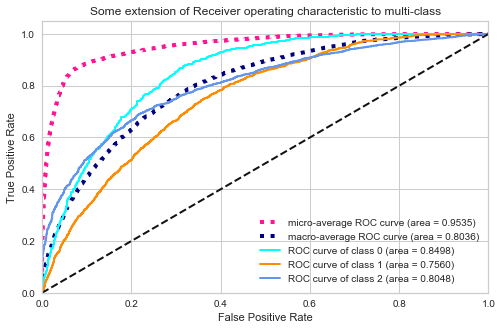

In [106]:
y_test = label_binarize(y_test, classes=[0,1,2])
n_classes = y_test.shape[1]
y_score = xgb.predict_proba(x_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
lw = 2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.4f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

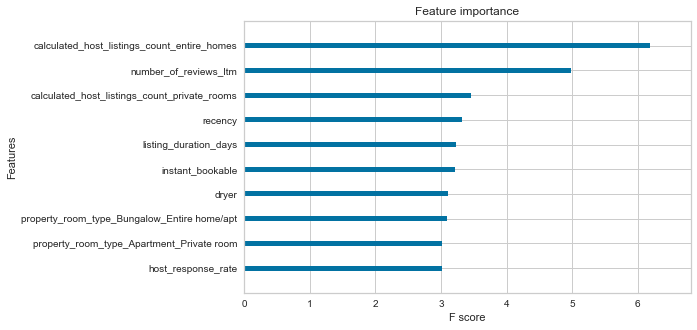

In [107]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 5)
#plot_importance(mymodel, importance_type='cover', max_num_features = 10,show_values=False)
plot_importance(xgb, importance_type='gain', max_num_features = 10,show_values=False)